In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from operator import itemgetter
import matplotlib as mpl
import matplotlib.pyplot as plt
from timeit import time
import itertools # para generar las permutaciones del exhaustivo
import matplotlib.pyplot as plt

capitales = pd.read_csv('capitales.csv')

# ------------------------ formateo de tabla de distancias
tabla_distancias = pd.read_csv('distancias_capitales.csv')
tabla_distancias = tabla_distancias.rename(columns={'Distancias en kilómetros': 'Capital'})
columnas = ['capital']
for i in range(24):
    columnas.append(i)
tabla_distancias.columns = columnas
# ------------------------

In [30]:
capitales=pd.read_excel('CapitalesArg.xlsx', index_col=None, header=None)
a=[]
a=list(capitales[1][1:24])
b=[]
for i in range(len(a)):
    if type(a[i])!=float:
        b.append(int(a[i]))
print(b[:])
print(str(np.min(b)))
min=str(np.min(b))
recorrido=[]
capis=capitales[1][1:24]
for id, cap in enumerate (capis):
                if cap==min:
                    recorrido.append(str(id+1))
print(recorrido)

[646, 792, 933, 53, 986, 985, 989, 375, 834, 1127, 794, 2082, 979, 1080, 1334, 1282, 1005, 749, 393, 579, 939, 2373]
53
['5']


In [ ]:
def formatear(tabla_capitales, recorrido):
    # devuelve una tabla con latitudes y longitudes, ordenada por orden de recorrido lista para ser impresa en el mapa
    tabla_final = pd.DataFrame(columns=['capital', 'latitud', 'longitud'])
    
    for i in range(len(recorrido)):
        tabla_final = tabla_final.append(tabla_capitales.iloc[recorrido[i]])
        
    return tabla_final

# Método Heuristico con Restricción de Ciudad

In [2]:
def main_heuristicoA(tabla_distancias, nro_ciudad):
    t0 = time.perf_counter()

    recorrido = []
    recorrido.append(nro_ciudad)
    distancia_recorrida = 0
    
    id_capital_sig = nro_ciudad #
    tabla_auxiliar = tabla_distancias[id_capital_sig].copy() #inicializar tabla auxiliar

    while len(recorrido) < len(tabla_distancias):  # len(tabla_distancias) -> 24
    
        distancia_mas_cercana = tabla_auxiliar.min()
        id_capital_sig = tabla_auxiliar.idxmin()
        
        if id_capital_sig in recorrido:  # si verdadero, esa capital ya se visitó y por lo tanto se elimina de tabla auxiliar
            tabla_auxiliar = tabla_auxiliar.drop(id_capital_sig) 
        else:
            distancia_recorrida += distancia_mas_cercana  
            recorrido.append(id_capital_sig)
            tabla_auxiliar = tabla_distancias[id_capital_sig].copy() # reinicio la tabla auxiliar para que tenga todas las filas
    
    recorrido.append(nro_ciudad) #vuelvo a la ciudad de inicio
    distancia_recorrida += tabla_distancias[recorrido[-1]][recorrido[-2]] # sumo la distancia de vuelta a casa
    tf = time.perf_counter()
    tiempo_ejecucion = tf - t0
    return recorrido, distancia_recorrida, tiempo_ejecucion

# Método Heurístico sin Ingreso de Ciudad

In [ ]:
def main_heuristicoB(tabla_distancias):
    t0 = time.perf_counter()
    menor_distancia = 99999999999

    for i in range(len(tabla_distancias)):
        recorrido_actual = []
        recorrido_actual.append(i)
        distancia_recorrida = 0
        tabla_auxiliar = tabla_distancias[i].copy() #inicializar tabla auxiliar

        while len(recorrido_actual) < len(tabla_distancias): 
            distancia_mas_cercana = tabla_auxiliar.min()
            id_capital_sig = tabla_auxiliar.idxmin()
            
            if id_capital_sig in recorrido_actual:  # si verdadero, esa capital ya se visitó y por lo tanto se elimina de tabla auxiliar
                tabla_auxiliar = tabla_auxiliar.drop(id_capital_sig) 
            else:
                distancia_recorrida += distancia_mas_cercana  
                recorrido_actual.append(id_capital_sig)
                tabla_auxiliar = tabla_distancias[id_capital_sig].copy() # reinicio la tabla auxiliar para que tenga todas las filas
        
        recorrido_actual.append(i) #vuelvo a la ciudad de inicio
        distancia_recorrida += tabla_distancias[recorrido_actual[-1]][recorrido_actual[-2]] # sumo la distancia de vuelta a casa

        if distancia_recorrida < menor_distancia:
            menor_distancia = distancia_recorrida
            menor_recorrido = recorrido_actual

    tf = time.perf_counter()
    tiempo_ejecucion = tf - t0
    return menor_recorrido, menor_distancia, tiempo_ejecucion

# Resolución con Alg. Genéticos

In [2]:
def inicializar(tamaño_poblacion, longitud_cromosoma):
    poblacion_inicial = []
    for i in range(tamaño_poblacion):
        num = []
        num.append(np.random.randint(0,24))
        for i in range(1, longitud_cromosoma-1):
            band=True
            while(band==True):
                prov=np.random.randint(0,24)
                repetido=0
                for j in (num):
                    if prov==j:
                        repetido=repetido+1
                if repetido<1:
                    num.append(prov)
                    band=False
        num.append(num[0])
        poblacion_inicial.append(num)

    return poblacion_inicial

In [3]:
def mutacion(cromosoma):
    # se aplica una swap mutation.
    aux = cromosoma[:-1]  # aux es el cromosoma pero sin la vuelta a casa
    
    provA = np.random.randint(0, len(cromosoma)-1)
    provB = np.random.randint(0, len(cromosoma)-1)
    band=False
    while (band==False):
        if provA==provB:
            provB = np.random.randint(0, len(cromosoma)-1)
        else:
            band=True
    A=aux[provA]
    B=aux[provB]
    aux[provA]=B
    aux[provB]=A
    
    aux.append(aux[0]) # vuelvo a agregar la vuelta a casa
    return aux

In [4]:
def crossover_ciclico(padre1, padre2):
    
    hijo1 = []
    hijo2 = []
    for i in range(len(padre1)):
        hijo1.append(-1)
        hijo2.append(-1)
        
    # HIJO 1
    valor_inicial = padre1[0]
    hijo1[0] = valor_inicial
    gen = padre2[0]
 
    i = 1
    while True:
        if padre1[0] == padre2[0]:
            break
        if padre1[i] == gen:
            hijo1[i] = gen
            gen = padre2[i]
            if valor_inicial == padre2[i]:
                break
        if i >= len(padre1)-1:
            i = 1
        else:
            i += 1
    #intercambiar los que quedaron vacíos
    for i, prov in enumerate(hijo1):
        if prov == -1:
            hijo1[i] = padre2[i]
            
    # HIJO 2
    valor_inicial = padre2[0]
    hijo2[0] = valor_inicial
    gen = padre1[0]
 
    i = 1
    while True:
        if padre1[0] == padre2[0]:
            break
        if padre2[i] == gen:
            hijo2[i] = gen
            gen = padre1[i]
            if valor_inicial == padre1[i]:
                break
        if i >= len(padre1)-1:
            i = 1
        else:
            i += 1
    
    #intercambiar los que quedaron vacíos
    for i, prov in enumerate(hijo2):
        if prov == -1:
            hijo2[i] = padre1[i]
    
    return hijo1, hijo2

In [5]:
def funcion_objetivo(tabla_distancias, recorrido):
    '''
    dado un recorrido [ciudad 1, ciudad 2,  .., ciudad n, ciudad 1], calcula la longitud del trayecto
    '''
    distancia_recorrida = 0
    for i in range(len(recorrido) - 1):
        distancia_actual = tabla_distancias[recorrido[i]][recorrido[i+1]]
        distancia_recorrida += distancia_actual
    return distancia_recorrida

In [6]:
def fitness(cromosoma, f_obj, distancias):
    #fitness=[(fobj - recorrido) / fobj)]
    recorrido=0
    id=0
    for prov in cromosoma:
        if id < len(cromosoma) - 1:
            recorrido=int(distancias[int(prov)][int(cromosoma[id+1])])+recorrido
            id=id+1
    recorrido=recorrido+int(distancias[int(cromosoma[-2])][int(cromosoma[-1])])
    fitness=(f_obj-recorrido)/f_obj
    return fitness

In [7]:
def fitness_v2(poblacion, cromosoma):
    objetivo_cromosoma = funcion_objetivo(tabla_distancias, cromosoma)
    
    suma_objetivo = 0
    for r in poblacion:
        suma_objetivo += funcion_objetivo(tabla_distancias, r)
        
    suma_complemento = 0
    for r in poblacion:
        suma_complemento += suma_objetivo - funcion_objetivo(tabla_distancias, r)
        
    fitness = (suma_objetivo - objetivo_cromosoma) / suma_complemento
    return fitness

In [8]:
def seleccionar(lista_poblacion, distancias, elitismo = False):
    id_seleccionado = 0
    padres = []

    if elitismo:
        padres.append(lista_poblacion[0][1]) #los dos individuos elitistas
        padres.append(lista_poblacion[1][1])
    else:
        # RULETA 
        while len(padres) < 2:  # porque necesitamos dos padres
            num_aleatorio = np.random.rand()    
            fitness_acumulada = lista_poblacion[0][2]
            i = 0
            
            while(fitness_acumulada < 1):
                if num_aleatorio <= fitness_acumulada:
                    id_seleccionado = lista_poblacion[i][0]
                    break
                else: 
                    i += 1
                    fitness_acumulada += lista_poblacion[i][2]
                    
            if fitness_acumulada == 1:
                id_seleccionado = lista_poblacion[-1][0]

            for sublista in lista_poblacion:
                if sublista[0] == id_seleccionado:
                    cromosoma_elegido = sublista[1]
                    break
                    
            if cromosoma_elegido not in padres:
                padres.append(cromosoma_elegido)
                
    return padres[0], padres[1]

In [9]:
def generar_estadisticos(poblaciones, tabla_distancias):
    '''Genera la tabla, cada fila es una población'''
    resultados = [[],[],[],[],[]] # suma de objetivos en poblacion, recorrido minimo, recorrido maximo, mediana recorridos, mejor cromosoma
    
    for poblacion in poblaciones:
        recorridos = []
        menor_recorrido = 999999999
        for cromosoma in poblacion:
            recorrido = funcion_objetivo(tabla_distancias, cromosoma)
            recorridos.append((cromosoma, recorrido))   
            
            if recorrido < menor_recorrido:
                mejor_cromosoma = cromosoma
                menor_recorrido = recorrido
        recorridos = np.array(recorridos)

        resultados[0].append(np.sum(recorridos[:, 1]))
        resultados[1].append(np.min(recorridos[:, 1]))
        resultados[2].append(np.max(recorridos[:, 1]))
        resultados[3].append(np.median(recorridos[:, 1]))
        resultados[4].append(mejor_cromosoma)
        
    df = pd.DataFrame(resultados).transpose()
    df.columns = ['Suma Recorridos Población', 'Recorrido Mínimo', 'Recorrido Máximo', 'Mediana de Recorridos', 'Mejor cromosoma']
    return df

In [10]:
def main(distancias, p_crossover=0.9, p_mutacion=0.2, ciclos=200, tamaño_poblacion=50, longitud_cromosoma=25, elitismo=True):
    t0 = time.perf_counter()
    
    poblacion_actual = inicializar(tamaño_poblacion, longitud_cromosoma)
    poblaciones = []
    poblaciones.append(poblacion_actual)
    cantidad_selecciones = tamaño_poblacion // 2

    for i in range(ciclos):  
        print(f'ciclo actual: {i}')
        lista_poblacion = []
        for id, individuo in enumerate(poblacion_actual):
            lista_poblacion.append([id, individuo, fitness_v2(poblacion_actual, individuo)])
        lista_poblacion = sorted(lista_poblacion, key=itemgetter(2), reverse=True)

        poblacion_nueva = []
        if elitismo:
            padre_1, padre_2 = seleccionar(lista_poblacion, distancias, elitismo)           
            poblacion_nueva.append(padre_1)
            poblacion_nueva.append(padre_2)
        
        for j in range(cantidad_selecciones+1):
         
            if len(poblacion_nueva) == tamaño_poblacion:
                continue
                
            # SELECCIONAR
            padre_1, padre_2 = seleccionar(lista_poblacion, distancias, False)

            # CRUZAR
            if np.random.rand() <= p_crossover:
                hijo_1, hijo_2 = crossover_ciclico(padre_1[:-1], padre_2[:-1])
                hijo_1.append(hijo_1[0])   # para que el hijo vuelva a casa
                hijo_2.append(hijo_2[0])   # para que el hijo vuelva a casa

            else: 
                hijo_1 = padre_1
                hijo_2 = padre_2

            # MUTAR
            if np.random.rand() <= p_mutacion:
                hijo_1 = mutacion(hijo_1)
            if np.random.rand() <= p_mutacion:
                hijo_2 = mutacion(hijo_2)

            # PASAR A PROXIMA GENERACION
            poblacion_nueva.append(hijo_1)
            if len(poblacion_nueva) != tamaño_poblacion:
                poblacion_nueva.append(hijo_2)

        poblacion_actual = poblacion_nueva
        
        poblaciones.append(poblacion_nueva)
    tf = time.perf_counter()
    
    poblaciones_df = pd.DataFrame(poblaciones)
    resultados = generar_estadisticos(poblaciones, tabla_distancias)
    tiempo_ejecucion = tf - t0
    
    return resultados, tiempo_ejecucion

In [11]:
resultados, tiempo = main(tabla_distancias, ciclos = 10, tamaño_poblacion=50, elitismo=False)
resultados

ciclo actual: 0
ciclo actual: 1
ciclo actual: 2
ciclo actual: 3
ciclo actual: 4
ciclo actual: 5


KeyboardInterrupt: 

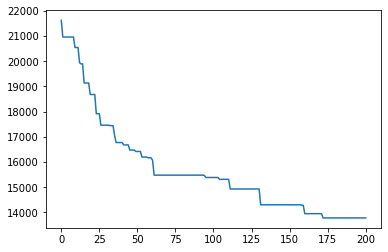

In [56]:
plt.plot(resultados['Recorrido Mínimo'])

# Método Exhaustivo

In [5]:
def generar_recorridos_posibles(cantidad_ciudades):
    '''
    componente para el método exhaustivo. Genera todos los recorridos posibles de longitud cantidad_ciudades
    siempre partiendo desde Bs. As. (para simplificar)
    '''
    aux = list(itertools.permutations([i for i in range(cantidad_ciudades)])) # generar permutaciones de las capitales
    
    recorridos_posibles = []
    for recorrido in aux:
        recorrido_aux = list(recorrido)   # itertools devuelve tuplas pero lo paso a listas
        recorrido_aux.append(recorrido[0]) # para que vuelva a la ciudad de partida
        recorridos_posibles.append(recorrido_aux)
    return recorridos_posibles

In [9]:
def main_exhaustivo(tabla_distancias, cantidad_ciudades):

    distancia_minima = 9999999999
    t0 = time.perf_counter()
    recorridos_posibles = generar_recorridos_posibles(cantidad_ciudades)

    for recorrido in recorridos_posibles:
        distancia_recorrida = funcion_objetivo(tabla_distancias, recorrido)
        if distancia_recorrida < distancia_minima:
            distancia_minima = distancia_recorrida
            recorrido_minimo = recorrido

    t1 = time.perf_counter()
    tiempo_ejecucion = t1 - t0

    return recorrido_minimo, distancia_minima, tiempo_ejecucion

In [ ]:
t = []
for x in range(3,11):
    print(x)
    r, d, tiempo = main_exhaustivo(tabla_distancias, x)
    t.append(tiempo)
print(t)

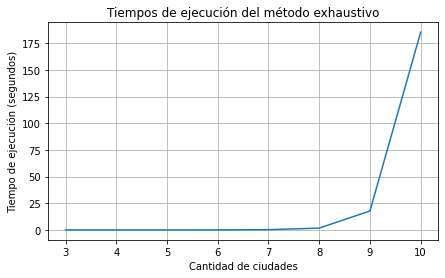

In [19]:
plt.figure(figsize= (7,4))
plt.ylabel('Tiempo de ejecución (segundos)')
plt.xlabel('Cantidad de ciudades')
plt.title('Tiempos de ejecución del método exhaustivo')
plt.grid()
plt.plot(range(3,11), t)
plt.savefig('tiempos-exhaustivo-viajante.png', dpi=200)